In [1]:
%load_ext autoreload
%autoreload 2

In [184]:
from collections import namedtuple

from brian2 import *
from utils.equations import (
    dndt,
    m_s, 
    h_s,
    h_f,
    gNa18_eq,
)
from utils.funcs import (
    basic_namespace,
    plot_v_by_equation,
    compIFcurve_by_equation,
    plotIFcurve,
)


prefs.codegen.target = "numpy"

## Токи

In [4]:
basic_I = Equations("""
INa = gNa*m**3*h*(Ena-v) : amp
IK = gK*n**4*(Ek-v) : amp
I : amp
""")
base_master_eq = Equations("""
dv/dt = (gL * (El - v) + IK + INa + I) / Cm : volt""")
dmdt = Equations(
"""
dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32*4*0.8 / exprel((13*mV - v + VT + 3*mV)/4/mV) / ms : Hz
b_m = 0.28 * 5 / exprel((v - VT - 40*mV + 3*mV)/5/mV) / ms : Hz
"""
)
dhdt = Equations(
"""
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*0.2*exp((17*mV - v + VT + 15*mV)/18/mV) / ms : Hz
b_h = 4*0.2 / (1 + exp((40*mV - v + VT + 15*mV)/5/mV)) / ms : Hz
"""
)
base_eq = base_master_eq + basic_I + dndt + dhdt + dmdt

In [30]:
Knav_master_eq = Equations(
    """
dv/dt = (gL * (El - v) + IK + INa + INav18 + I) / Cm : volt
INav18 = gNa18 * m_s**3 * h_s * (Ena - v) : amp
"""
)
Knav_eq = Knav_master_eq + basic_I + dndt + dhdt + dmdt + m_s + h_s

In [50]:
K2nav_master_eq = Equations(
"""
dv/dt = (gL * (El - v) + IK + INa + INa18s + INa18f + I) / Cm : volt
INa18s = gNa18 * m_s**3 * h_s * (Ena - v) : amp
INa18f = gNa18 * m_s**3 * h_f * (Ena - v) : amp
"""
)
K2nav_eq = K2nav_master_eq + basic_I + dndt + dhdt + dmdt + m_s + h_s + h_f

In [42]:
Lnav_master_eq = Equations(
    """
dv/dt = (gL * (El - v) + IK + INa + INa18 + I) / Cm : volt
"""
)
Lnav_eq = Lnav_master_eq + basic_I + dndt + dhdt + dmdt + gNa18_eq

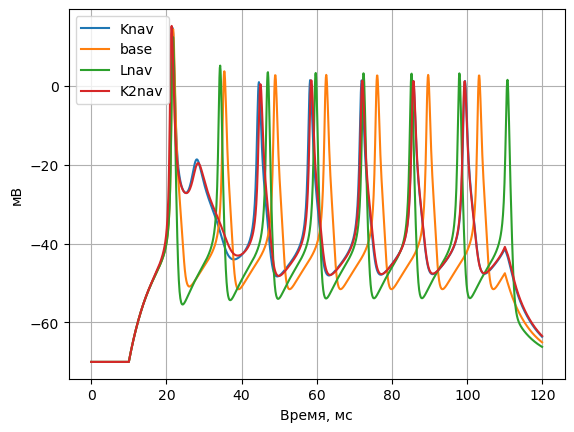

In [51]:
# compare spiking
lowna18_namespace = basic_namespace.copy()
lowna18_namespace.update(
    {"gNa18": 50*nS}
)
plot_v_by_equation(Knav_eq, lowna18_namespace)
plot_v_by_equation(base_eq, basic_namespace)
plot_v_by_equation(Lnav_eq, lowna18_namespace)
plot_v_by_equation(K2nav_eq, lowna18_namespace)
legend(["Knav", "base", "Lnav", "K2nav"])

In [45]:
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, basic_namespace)
Knavifmon, Knavifgroup = compIFcurve_by_equation(Knav_eq, lowna18_namespace)
Lnavifmon, Lnavifgroup = compIFcurve_by_equation(Lnav_eq, lowna18_namespace)
K2navifmon, K2navifgroup = compIFcurve_by_equation(K2nav_eq, lowna18_namespace)

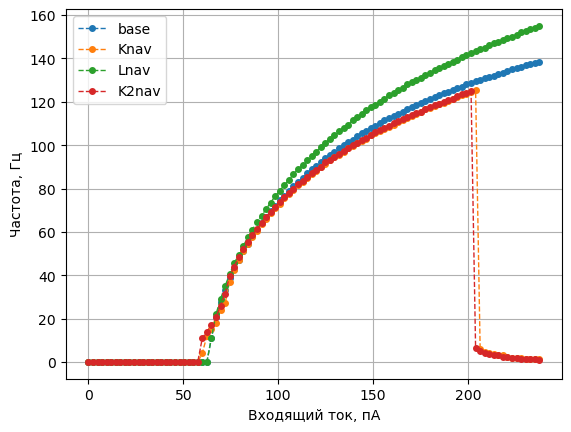

In [53]:
plotIFcurve(baseifmon, baseifgroup)
plotIFcurve(Knavifmon, Knavifgroup)
plotIFcurve(Lnavifmon, Lnavifgroup)
plotIFcurve(K2navifmon, K2navifgroup)
legend(["base", "Knav", "Lnav", "K2nav"])

Промежуточный вывод по графику выше. \
Проводимость для Nav18 = 50 nS. \
Во-первых. Не слишком большая разница. \
Во-вторых. Эта разница проявляется на больших токах. А нас интересуют именно что маленькие токи.

Есть мысль подвигать проводимость gl. \
А ещё можно "поближе" посмотреть на зависимости при малых токах.

Почему так? Натриевые токи не такие эффективные.

- ~~добавить лит. нав18~~
- ~~добавить К нав18 + h_f~~
- двигать проводимость, следить за if-curve

Неудобно результаты смотреть. Надо завести за правило - расчёты отдельно, визуализация - отдельно.


In [125]:
test_Gna18s = arange(25, 225, 25) * nS
gnas_legend = list(test_Gna18s/nS)
TestIfData = namedtuple("TestIfData", ["ifmon", "ifgroup"])
test_namespace = basic_namespace.copy()
gna80_namespace = basic_namespace.copy()
gna80_namespace["gNa"] = 80 * nS
gna20_namespace = basic_namespace.copy()
gna20_namespace["gNa"] = 20 * nS

In [123]:
# для сравнения набор данных
gna80ifmon, gna80ifgroup = compIFcurve_by_equation(base_eq, gna80_namespace)
gna20ifmon, gna20ifgroup = compIFcurve_by_equation(base_eq, gna20_namespace)

#### Knav HIGH

In [120]:
# Knav eq
Knav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 80 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(Knav_eq, test_namespace)
    Knav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)

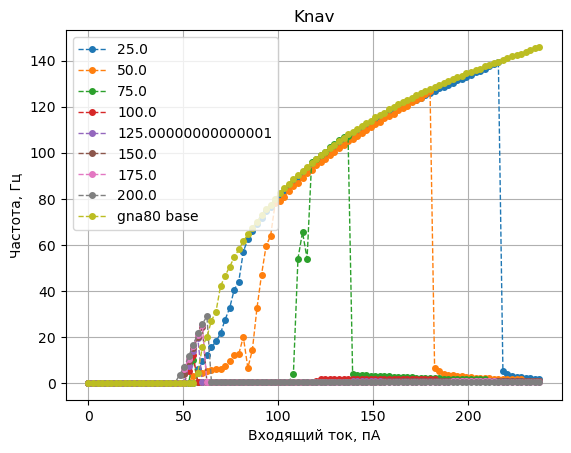

In [126]:
for gna18 in test_Gna18s/nS:
    plotIFcurve(Knav_if[gna18].ifmon, Knav_if[gna18].ifgroup)

title("Knav")
plotIFcurve(gna80ifmon, gna80ifgroup)
legend(gnas_legend+["gna80 base"])

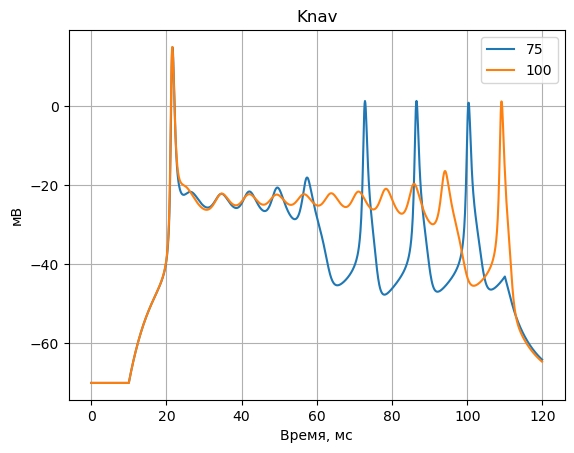

In [99]:
changeNav18_namespace = basic_namespace.copy()
changeNav18_namespace["gNa18"] = 75 * nS
title("Knav")
plot_v_by_equation(Knav_eq, changeNav18_namespace)
changeNav18_namespace["gNa18"] = 100 * nS
plot_v_by_equation(Knav_eq, changeNav18_namespace)
legend(["75", "100"])

#### Knav LOW

In [127]:
# Knav eq
Knav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 20 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(Knav_eq, test_namespace)
    Knav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)

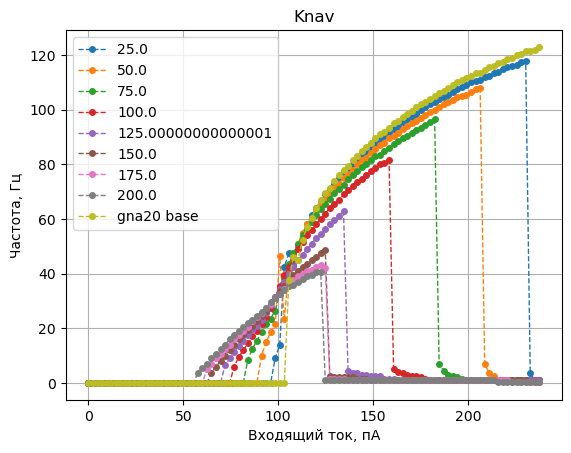

In [129]:
for gna18 in test_Gna18s/nS:
    plotIFcurve(Knav_if[gna18].ifmon, Knav_if[gna18].ifgroup)

title("Knav")
plotIFcurve(gna20ifmon, gna20ifgroup)
legend(gnas_legend+["gna20 base"])

ООООООЧЕНЬ СТРАННО

#### K2nav HIGH

In [118]:
# K2nav eq
K2nav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 80 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(K2nav_eq, test_namespace)
    K2nav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)


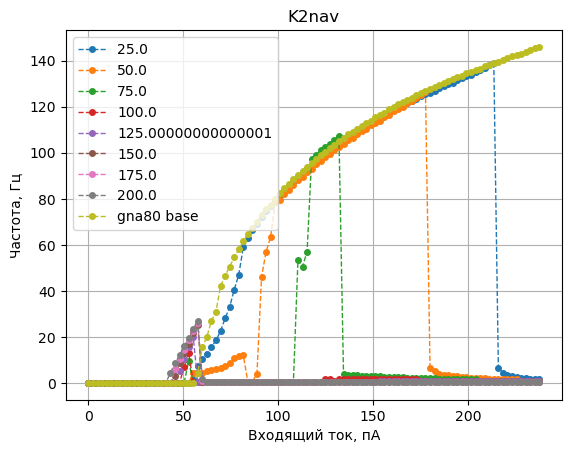

In [130]:
for gna18 in test_Gna18s/nS:
    plotIFcurve(K2nav_if[gna18].ifmon, K2nav_if[gna18].ifgroup)

title("K2nav")
plotIFcurve(gna80ifmon, gna80ifgroup)
legend(gnas_legend+["gna80 base"])

##### просто посмотрел, как выглядят спайки

In [155]:
start_scope()
defaultclock.dt = 0.1*ms
gna18 = 25 * nS
gna = 20 * nS
particularK2nav_namespace = basic_namespace.copy()
particularK2nav_namespace["gNa"] = gna
particularK2nav_namespace["gNa18"] = gna18
k2_group = NeuronGroup(1, K2nav_eq, namespace=particularK2nav_namespace, method="exponential_euler")
k2_mon = StateMonitor(k2_group, "v", record=True)
k2_group.v = -70*mV
run(10*ms)
k2_group.I = 70 * pA
run(100*ms)
k2_group.I = 0*pA
run(10*ms)

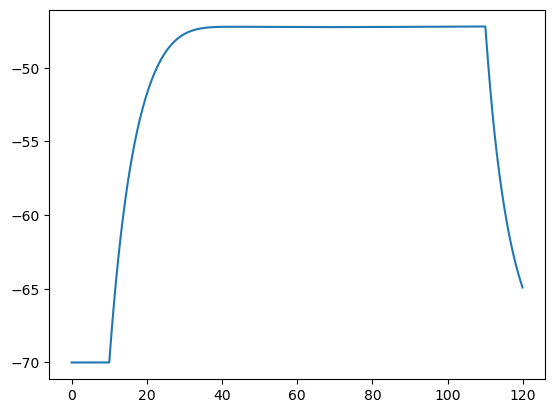

In [156]:
plot(k2_mon.t/ms, k2_mon.v[0]/mV)

#### K2nav LOW

In [131]:
# K2nav eq
K2nav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 20 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(K2nav_eq, test_namespace)
    K2nav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)

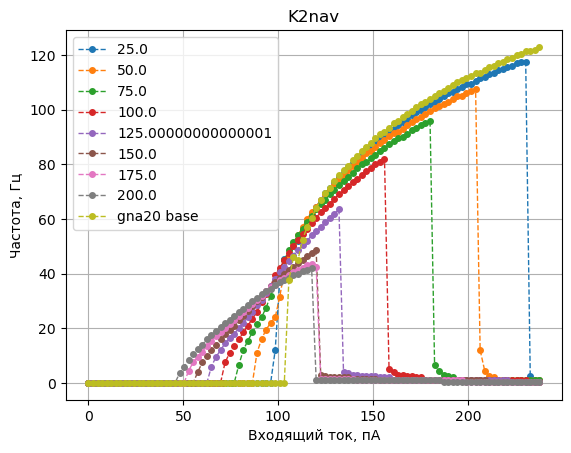

In [134]:
for gna18 in test_Gna18s/nS:
    plotIFcurve(K2nav_if[gna18].ifmon, K2nav_if[gna18].ifgroup)

title("K2nav")
plotIFcurve(gna20ifmon, gna20ifgroup)
legend(gnas_legend+["gna20 base"])

На проводимости от 50 до 75, происходит "схлопывание" спайковой активности.

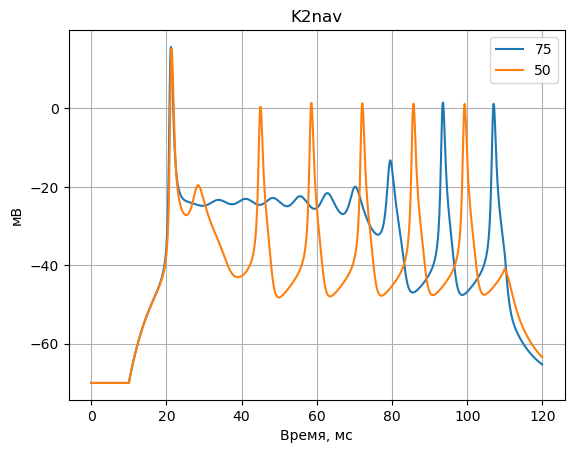

In [98]:
# хочу посмотреть, что там "реально" происходит
changeNav18_namespace = basic_namespace.copy()
changeNav18_namespace["gNa18"] = 75 * nS
title("K2nav")
plot_v_by_equation(K2nav_eq, changeNav18_namespace)
changeNav18_namespace["gNa18"] = 50 * nS
plot_v_by_equation(K2nav_eq, changeNav18_namespace)
legend(["75", "50"])

#### Lnav high gNa

In [107]:
# Lnav eq
Lnav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 80 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(Lnav_eq, test_namespace)
    Lnav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)

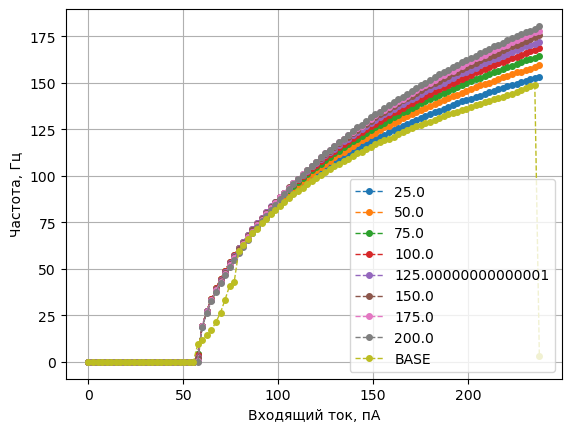

In [108]:
for gna18 in test_Gna18s/nS:
    plotIFcurve(Lnav_if[gna18].ifmon, Lnav_if[gna18].ifgroup)

plotIFcurve(baseifmon, baseifgroup)
LEGEND = list(test_Gna18s/nS) + ["BASE"]
legend(LEGEND)

#### Lnav low gNa

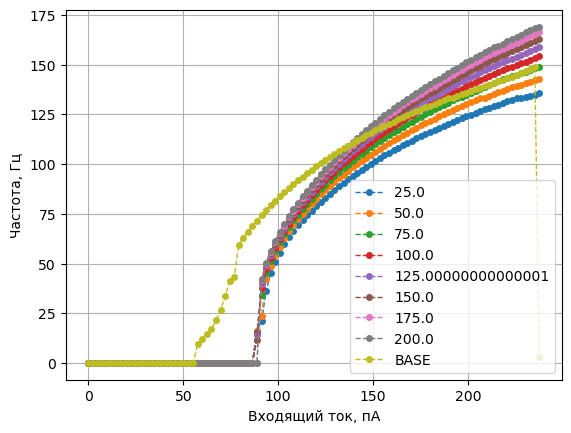

In [117]:
# Lnav eq
Lnav_if = dict.fromkeys(test_Gna18s / nS)
for gna18 in test_Gna18s:
    test_namespace["gNa18"] = gna18
    test_namespace["gNa"] = 25 * nS
    test_ifmon, test_ifgroup = compIFcurve_by_equation(Lnav_eq, test_namespace)
    Lnav_if[gna18/nS] = TestIfData(test_ifmon, test_ifgroup)
for gna18 in test_Gna18s/nS:
    plotIFcurve(Lnav_if[gna18].ifmon, Lnav_if[gna18].ifgroup)

low_baseifmon, low_baseifgroup = compIFcurve_by_equation(base_eq, test_namespace)
plotIFcurve(baseifmon, baseifgroup)
LEGEND = list(test_Gna18s/nS) + ["BASE"]
legend(LEGEND)

**Вывод по изменению проводимостей**

*пока какой-то треш, надо посмотреть, что реально происходит* \

Зато можно сказать, что **Lnav** вроде бы не особо подходит, абсолютно не то поведение, которое мы хотели бы

### Доп. исследование: а как себя base ведёт на своих проводимостях?



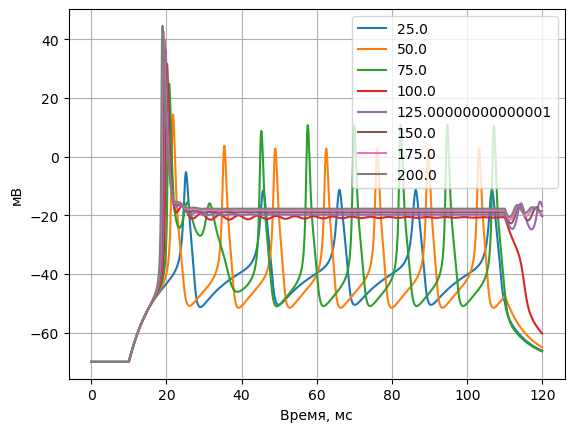

In [101]:
# broad look at
for gna in test_Gna18s:
    change_gna_namespace = basic_namespace.copy()
    change_gna_namespace["gNa"] = gna
    plot_v_by_equation(base_eq, change_gna_namespace)
legend(test_Gna18s/nS)

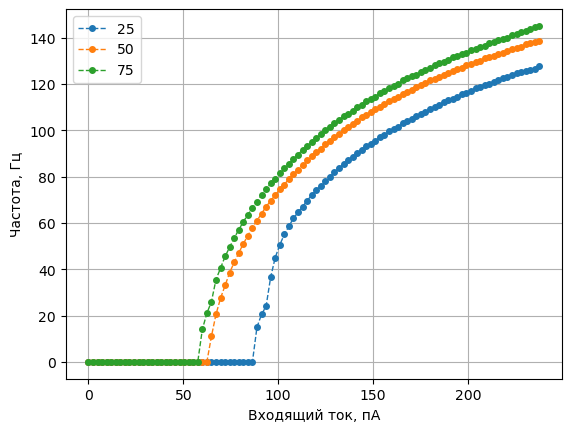

In [102]:
# broad gna grid search (IF curves)
for gna in [25, 50, 75]*nS:
    change_gna_namespace = basic_namespace.copy()
    change_gna_namespace["gNa"] = gna
    baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, change_gna_namespace)
    plotIFcurve(baseifmon, baseifgroup)
legend([25, 50, 75])

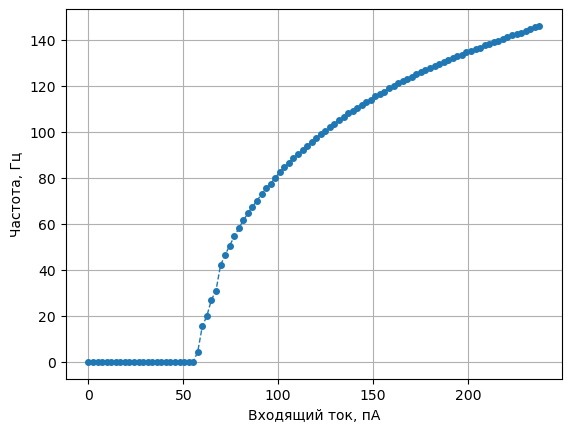

In [105]:
#  IF curve gna = 80
change_gna_namespace["gNa"] = 80 * nS
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, change_gna_namespace)
plotIFcurve(baseifmon, baseifgroup)

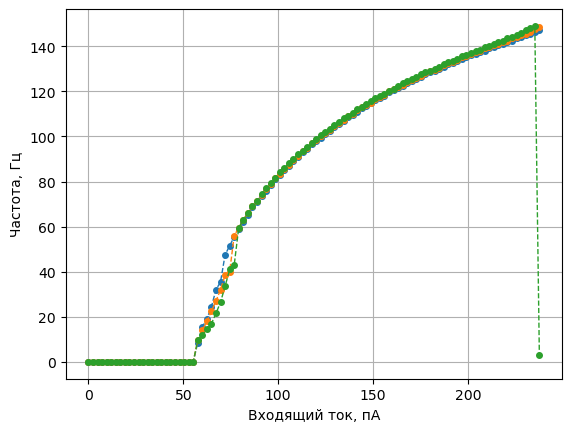

In [106]:
# fine grid search (85-95 gnas)
for gna in [85, 90, 95]*nS:
    change_gna_namespace = basic_namespace.copy()
    change_gna_namespace["gNa"] = gna
    baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, change_gna_namespace)
    plotIFcurve(baseifmon, baseifgroup)

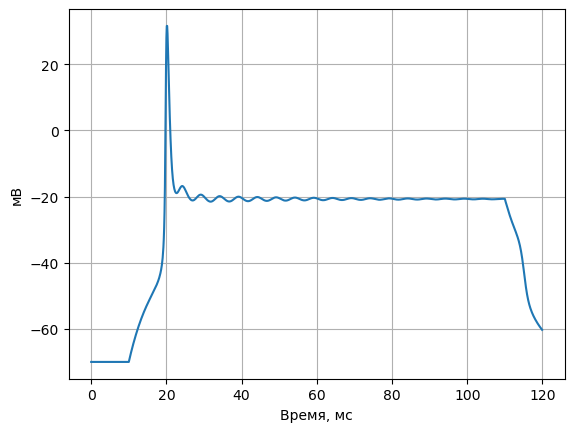

In [104]:
# spikes with higher gna
plot_v_by_equation(base_eq, change_gna_namespace)

## Выводы по каждому току

Достаём "удачные" параметры и смотрим на них (для каждого тока)

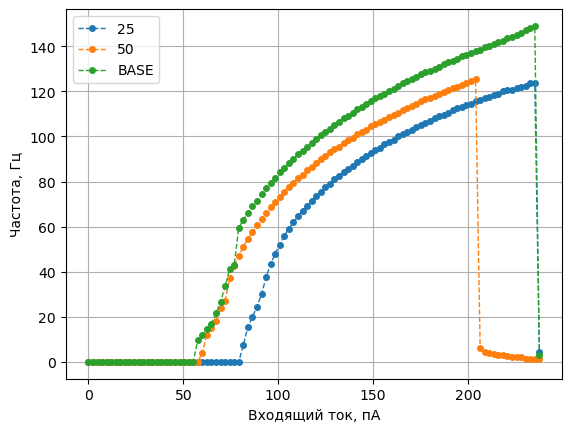

In [115]:
# Knav
Knav_if.keys()
plotIFcurve(Knav_if[25.0].ifmon, Knav_if[25.0].ifgroup)
plotIFcurve(Knav_if[50.0].ifmon, Knav_if[50.0].ifgroup)
plotIFcurve(baseifmon, baseifgroup)
legend([25, 50, "BASE"])

## Доп. исследование: как влияет gL

### low gL

#### base

In [176]:
# base
gl_namespace = basic_namespace.copy()
gl_namespace["gL"] = 1 * nS  # low gl

gnas = [25 * nS, 50 * nS, 75 * nS]
grid_search_gna_legend = [f"gna={gna}; gna18={gna18}" for gna in gnas for gna18 in gnas]

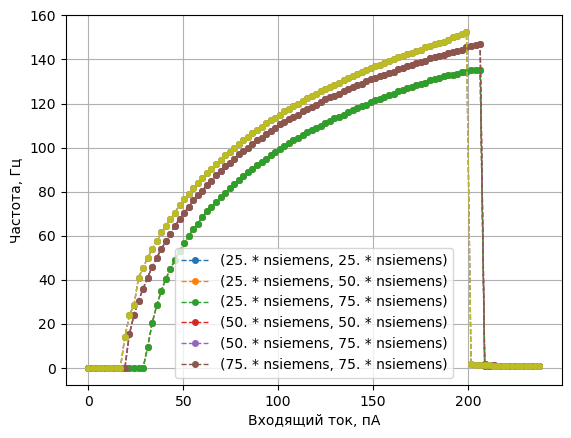

In [174]:
for gna in gnas:
    for gna18 in gnas:
        change_gna_namespace = gl_namespace.copy()
        change_gna_namespace["gNa"] = gna
        change_gna_namespace["gNa18"] = gna18
        baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, change_gna_namespace)
        plotIFcurve(baseifmon, baseifgroup)

legend(grid_search_gna_legend)

#### Knav


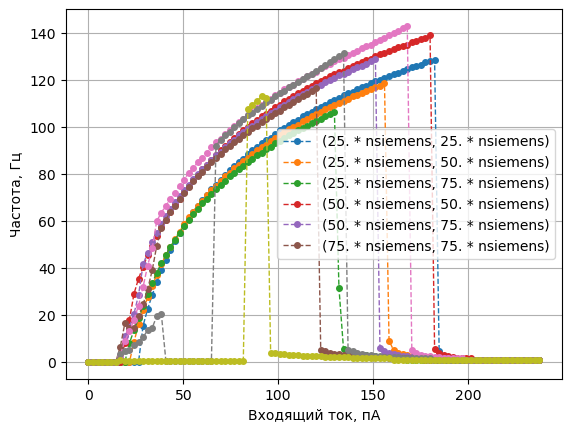

In [175]:
for gna in gnas:
    for gna18 in gnas:
        change_gna_namespace = gl_namespace.copy()
        change_gna_namespace["gNa"] = gna
        change_gna_namespace["gNa18"] = gna18
        Knavifmon, Knavifgroup = compIFcurve_by_equation(Knav_eq, change_gna_namespace)
        plotIFcurve(Knavifmon, Knavifgroup)

legend(grid_search_gna_legend)

### high gL

In [178]:
gl_namespace = basic_namespace.copy()
gl_namespace["gL"] = 5 * nS  # high gl

#### base

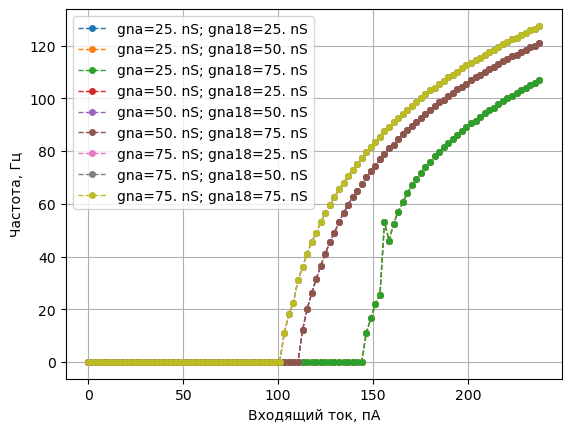

In [180]:
for gna in gnas:
    for gna18 in gnas:
        change_gna_namespace = gl_namespace.copy()
        change_gna_namespace["gNa"] = gna
        change_gna_namespace["gNa18"] = gna18
        baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, change_gna_namespace)
        plotIFcurve(baseifmon, baseifgroup)

legend(grid_search_gna_legend)

#### Knav

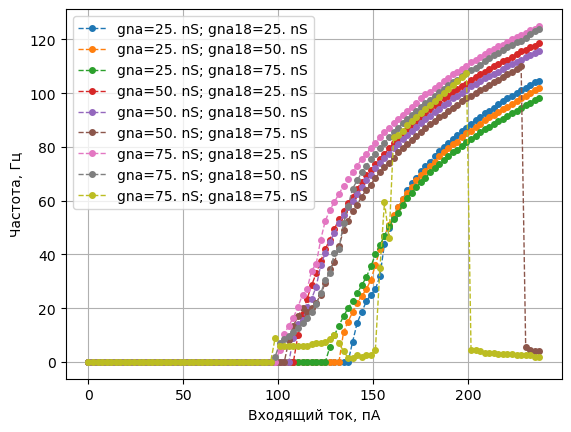

In [181]:
for gna in gnas:
    for gna18 in gnas:
        change_gna_namespace = gl_namespace.copy()
        change_gna_namespace["gNa"] = gna
        change_gna_namespace["gNa18"] = gna18
        Knavifmon, Knavifgroup = compIFcurve_by_equation(Knav_eq, change_gna_namespace)
        plotIFcurve(Knavifmon, Knavifgroup)

legend(grid_search_gna_legend)

In [ ]:
# rewrite if-curve function with less points and lesser max current
# look at base + modification (less curves)

In [207]:
one_namespace = basic_namespace.copy()
one_namespace["gNa"] = 20 * nS
one_namespace["gNa18"] = 50 * nS
one_namespace["gL"] = 1 * nS
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, one_namespace, max_cur=150, N=50)
knavifmon, knavifgroup = compIFcurve_by_equation(Knav_eq, one_namespace, max_cur=150, N=50)

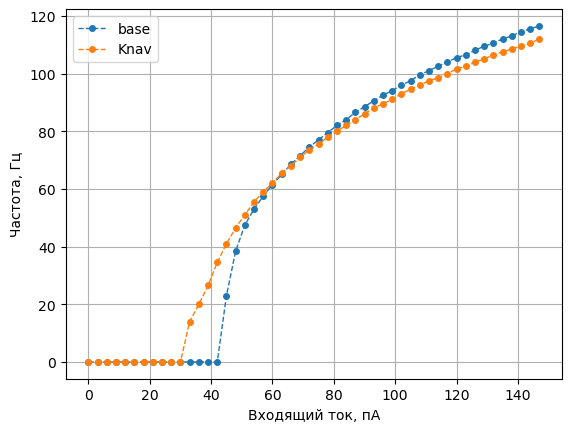

In [208]:
plotIFcurve(baseifmon, baseifgroup)
plotIFcurve(knavifmon, knavifgroup)
legend(["base", "Knav"])

In [209]:
one_namespace = basic_namespace.copy()
one_namespace["gNa"] = 20 * nS
one_namespace["gNa18"] = 50 * nS
one_namespace["gL"] = 1 * nS
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, one_namespace, max_cur=150, N=50)
knav2ifmon, kna2ifgroput = compIFcurve_by_equation(Knav_eq, one_namespace, max_cur=150, N=50)

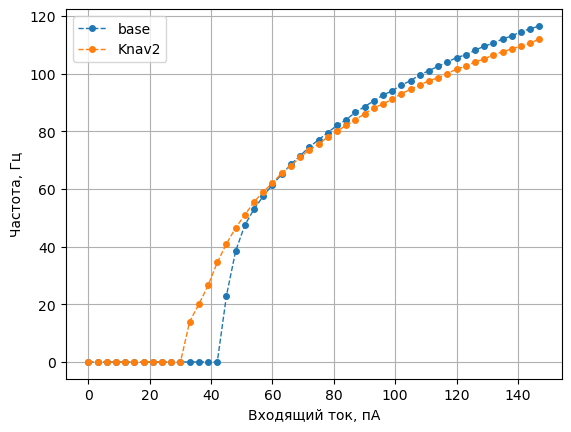

In [210]:
plotIFcurve(baseifmon, baseifgroup)
plotIFcurve(knav2ifmon, kna2ifgroput)
legend(["base", "Knav2"])

In [218]:
start_scope()
knav_neuron = NeuronGroup(1, Knav_eq, method="exponential_euler", namespace=one_namespace)
knav_mon = StateMonitor(knav_neuron, ["v", "h_s", "m_s", "m", "h"], record=True)

run(10*ms)
knav_neuron.I = 60*pA
run(100*ms)
knav_neuron.I = 0*pA
run(10*ms)

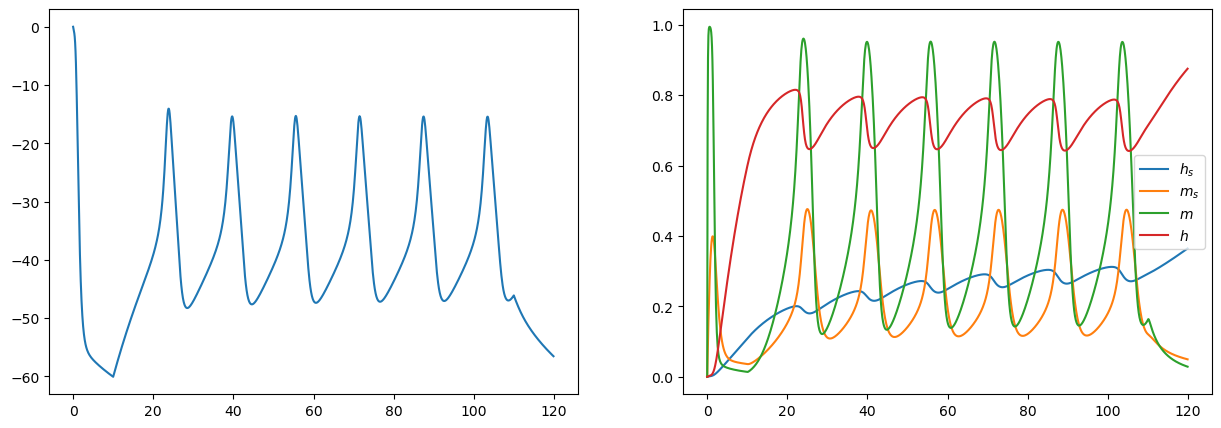

In [219]:
figure(figsize=(15,5))
subplot(121)
plot(knav_mon.t/ms, knav_mon.v[0]/mV)
subplot(122)
plot(knav_mon.t/ms, knav_mon.h_s[0], label="$h_s$")
plot(knav_mon.t/ms, knav_mon.m_s[0], label="$m_s$")
plot(knav_mon.t/ms, knav_mon.m[0], label="$m$")
plot(knav_mon.t/ms, knav_mon.h[0], label="$h$")
legend()